## Probability coverage test

Check uncertainties given by a probabilistic model assuming a Gaussian behaviour for the distributions predicted

We load the modules we need and define the format for the plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)

Load dataset (real values and model predictions)

In [3]:
#real values
index_sh=np.load('./saved_models/ind_sh.npy')
y=np.load('./saved_input/y.npy')[index_sh,:][135000:,:] #keep only test set (last 15.000 samples of the shuffled dataset)

#model predictions (median and standard deviation, if you use the mean the results are practically the same)
y_pred=np.load('./saved_models/means.npy')
y_pred_std=np.load('./saved_models/stds.npy')


Put all the predictions (9 percentiles and [M/H]) in a flatten list, instead of a 2D array

In [4]:
y_linear=[]
y_pred_linear=[]
y_pred_std_linear=[]

for i in range(10):
    for j in range(15000):
        y_linear.append(y[j,i])
        y_pred_linear.append(y_pred[j,i])
        y_pred_std_linear.append(y_pred_std[j,i])
print(np.shape(y_linear))

(150000,)


In statistics, for non-negative values ​​of $x$, the error function has the following interpretation: for a random variable $Y$ that follows a normal distribution with mean 0 and variance $1 / 2, \operatorname{erf}(x)$ is the probability that $Y$ falls in the interval $[-x, x]$. We perform the coverage probability test.  If the uncertainties are properly calibrated, the nominal coverage probability (percentage of probability volume), on the x-axis, would be equal to the coverage probability (percentage of actual values in such volume), on the y-axis, assuming a Gaussian distribution. If they are not, the actual coverage probability could either be less than or greater than the nominal coverage probability. When the actual coverage probability is greater than the nominal coverage probability, the model is called 'conservative', if it is less than the nominal coverage probability, is called 'overconfident'.

In [5]:
def get_coverage_probabilities_nomodel(y_real,y_pred,y_pred_std):
    """
    Compute the coverage probabilities on test dataset
    
    :param y:  The data true values
    :param y_pred: The mean of the predicted distributions
    :param y_pred_std: The standard deviation of the predicted distributions
    :return: (x, y) a tuple of lists corresponding to a list of probability volumes
    and the corresponding percentage of true values in that volume.
    """

    errors = np.absolute(y_real - y_pred)
    x, y = [], []
    for sigma_times in np.arange(0, 3, 0.01):
        how_many = np.count_nonzero(errors <= sigma_times * y_pred_std)
        y.append(how_many / y_real.shape[0])
        x.append(math.erf(sigma_times / math.sqrt(2))) #the method erf returns the error function of a number.
    return x, y


def plot_with_median(data_x, data_y,ax, label=None, percentiles=(16, 84), total_bins=20):
    """
    Plot the running media of the data_x, data_y data with requested percentiles.
    :param data_x:
    :param data_y:
    :param label: The label that should be displayed on the legend
    :param percentiles: The percentiles to plot along with the median
    :param total_bins: The number of bins to digitize the data. Increase to increase detail.
    :return:
    """
    bins = np.linspace(data_x.min(), data_x.max(), total_bins)

    delta = bins[1] - bins[0]
    idx = np.digitize(data_x, bins)
    running_median = [np.nanmedian(data_y[idx == k]) for k in range(total_bins)]
    running_prc_low = [np.nanpercentile(data_y[idx == k], percentiles[0])
                       for k in range(total_bins)]
    running_prc_high = [np.nanpercentile(data_y[idx == k], percentiles[1])
                        for k in range(total_bins)]

    if percentiles:
        ax.plot(bins-delta/2, running_median, lw=2, alpha=.8, color='blue', label=label)
        ax.fill_between(bins - delta / 2, running_prc_low, running_median, color='blue', alpha=0.1)
        ax.fill_between(bins - delta / 2, running_prc_high, running_median, color='blue', alpha=0.1)
    else:
        ax.plot(bins - delta / 2, running_median, linestyle='--', lw=2, alpha=.8,  label=label)
        
        
def init_coverage_plot():
    """
    Initialize the coverage plot and add text for marking
    overconfident and conservative regions
    :return:
    """
    f = plt.figure()
    ax = f.add_subplot()
    ax.set_xlabel('Percentage of probability volume')
    ax.set_ylabel('Percentage of true values in volume')
    #ax.set_title('Probability Coverage')

    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.text(0.3, 0.6, 'Conservative',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)

    plt.text(0.7, 0.3, 'Overconfident',
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)
    return f, ax

Do a plot for each prediction

/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/patriglesiasnavarro/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


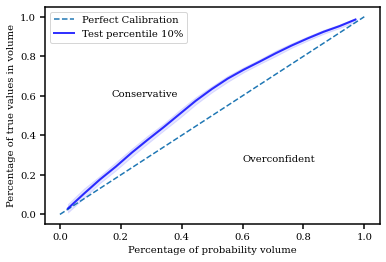

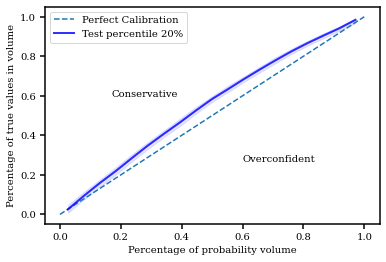

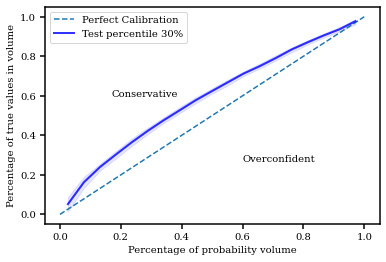

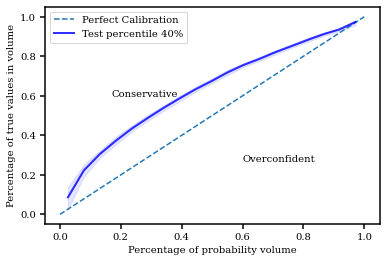

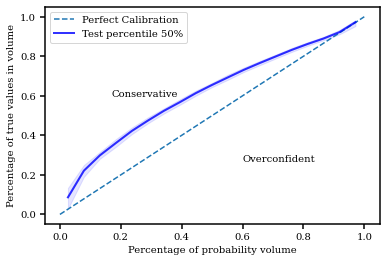

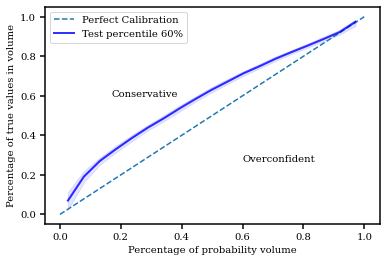

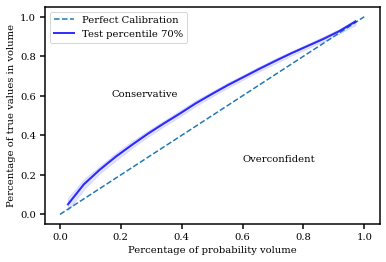

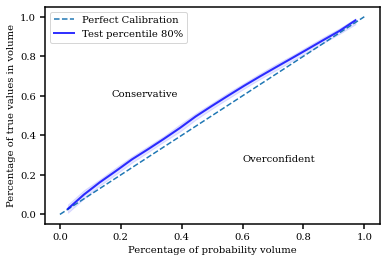

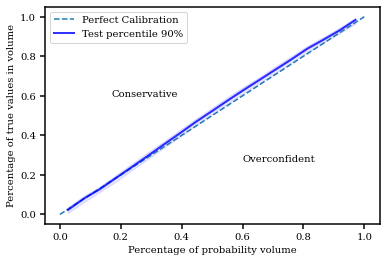

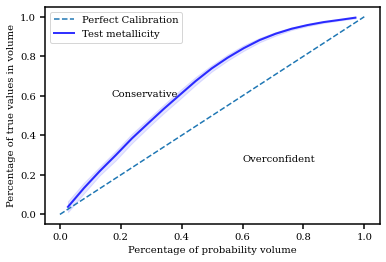

In [6]:
for i in range(10):
    
    data_x,data_y=get_coverage_probabilities_nomodel(np.array(y)[:,i],y_pred[:,i],y_pred_std[:,i])
    
    f, ax =init_coverage_plot()
    
    if i<9:
        plot_with_median(np.array(data_x), np.array(data_y), ax, label='Test percentile '+str((i+1)*10)+'%')
    elif i==9:
        plot_with_median(np.array(data_x), np.array(data_y), ax, label='Test metallicity')

    ax.legend()

    #plt.savefig('coverage_'+str(i)+'.pdf')
    plt.show()



Do a plot considering the totality of predictions

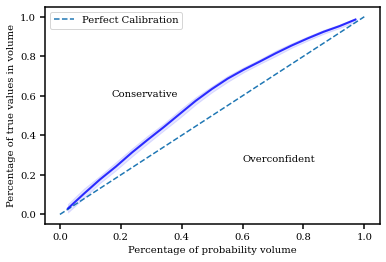

In [7]:
#full predictions
data_x,data_y=get_coverage_probabilities_nomodel(np.array(y_linear),np.array(y_pred_linear),np.array(y_pred_std_linear))
f, ax =init_coverage_plot()

plot_with_median(np.array(data_x), np.array(data_y), ax)

ax.legend()

#plt.savefig('coverage.pdf')
plt.show()
    